## Vault for Secrets, SSE-C for Encryption on S3

This very short tutorial allows you to read encrypted files on S3.
We will see how this tutorial is designed:
- Registering the secret in Vault (environment variables for this tutorial)
- Configuring the Spark driver

Each tutorial uses an environment context (environment variables) hosted in a "secret" that each user can read since it's placed in the "diffusion" folder. There are three variables: two that define the project to clone and the name of the tutorial.
The third one is the access secret to Trump's tweet data.

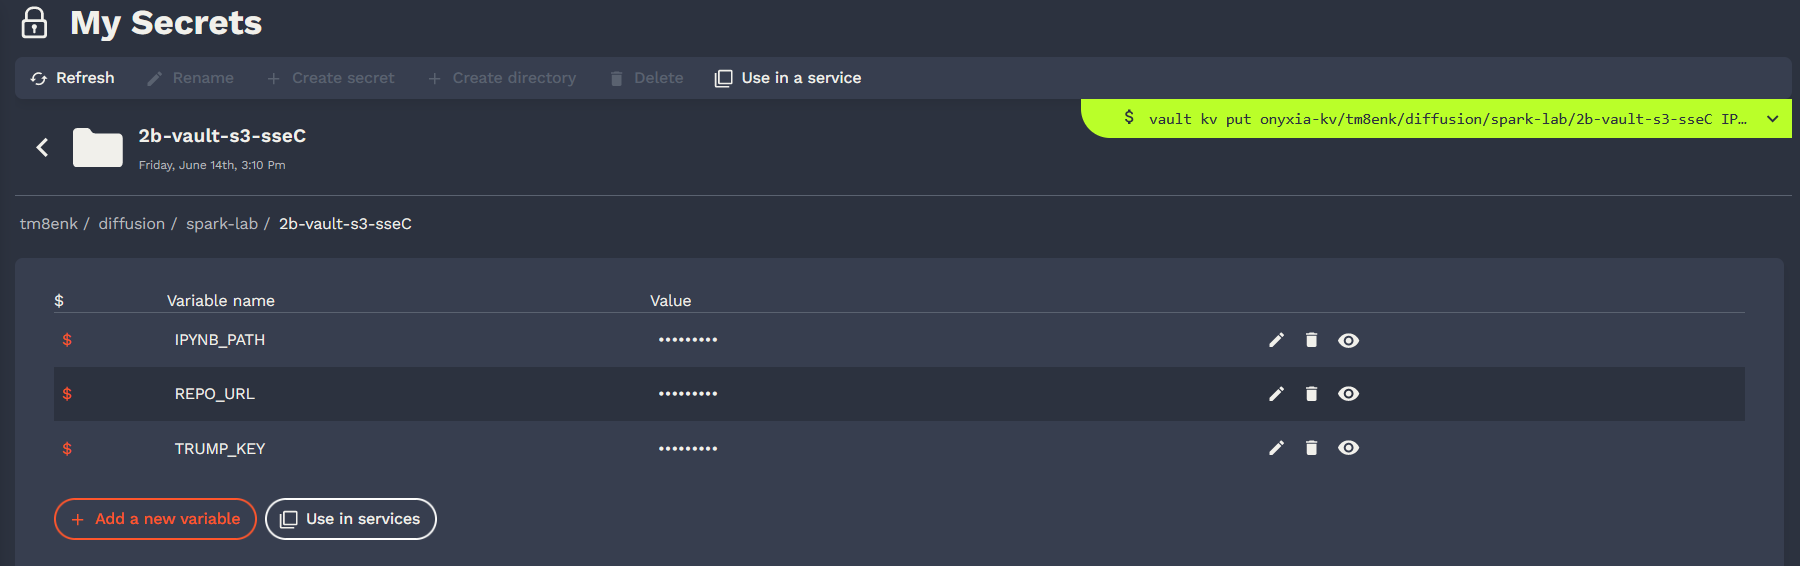

This environment context is passed in the URL of the tutorial deployment.
You will see that the Vault secret to load is relative to **tm8enk/diffusion/spark-lab/2b-vault-s3-sseC**
and that an init script takes care of cloning the project and placing you directly in the correct notebook:
[https://datalab.sspcloud.fr/launcher/ide/jupyter-pyspark?init.personalInit=https://raw.githubusercontent.com/InseeFrLab/spark-formation/main/init-notebook.sh&vault.secret=diffusion/spark-lab/2b-vault-s3-sseC&vault.directory=tm8enk&onyxia.friendlyName=2b_vault-s3-sseC](https://datalab.sspcloud.fr/launcher/ide/jupyter-pyspark?init.personalInit=https://raw.githubusercontent.com/InseeFrLab/spark-formation/main/init-notebook.sh&vault.secret=diffusion/spark-lab/2b-vault-s3-sseC&vault.directory=tm8enk&onyxia.friendlyName=2b_vault-s3-sseC)


In [1]:
#attention un vrai secret ne devrait jamais être affiché comme je le fais en dessous. Les outputs d'un notebook sont dans le format et donc accessible sur un dépot git.
!echo TRUMP_KEY=$TRUMP_KEY

TRUMP_KEY=


#### The Encrypted File on S3, a Bit of Command Line with `mc`

*trump_insult_tweets_2014_to_2021.csv.ssec* is an encrypted file that I have symbolically suffixed with .ssec. This is not mandatory, but I did it to illustrate what is encrypted and what is not.

You can easily read (with `mc`, for example) an unencrypted file, but it is impossible to access an encrypted file without providing the encryption key to S3.

In [2]:
!mc ls s3/projet-spark-lab/diffusion/formation/data/trump-tweets/

[2022-02-10 21:47:11 UTC] 2.7MiB STANDARD trump_insult_tweets_2014_to_2021.csv
[2022-10-07 15:44:04 UTC] 2.7MiB STANDARD trump_insult_tweets_2014_to_2021.csv.ssec


In [3]:
!mc head -n 1 s3/projet-spark-lab/diffusion/formation/data/trump-tweets/trump_insult_tweets_2014_to_2021.csv

"","date","target","insult","tweet"


In [4]:
!mc head -n 1 s3/projet-spark-lab/diffusion/formation/data/trump-tweets/trump_insult_tweets_2014_to_2021.csv.ssec

mc: <ERROR> Unable to read from `s3/projet-spark-lab/diffusion/formation/data/trump-tweets/trump_insult_tweets_2014_to_2021.csv.ssec`. The object was stored using a form of Server Side Encryption. The correct parameters must be provided to retrieve the object.


In [5]:
!mc head -n 1  --encrypt-key "s3/projet-spark-lab=$TRUMP_KEY" s3/projet-spark-lab/diffusion/formation/data/trump-tweets/trump_insult_tweets_2014_to_2021.csv.ssec 

"","date","target","insult","tweet"


#### Configuration Spark pour accèder à des fichiers chiffrés avec SSE-C 

In [6]:
from pyspark.sql import SparkSession
import os
import base64


spark = (SparkSession 
         .builder
         .appName("2b-vault-s3-sseC")
         .master("local[5]")
         .config("spark.hadoop.fs.s3a.server-side-encryption-algorithm", "SSE-C")
         .config("spark.hadoop.fs.s3a.server-side-encryption.key",
                 base64.b64encode(str.encode(os.environ['TRUMP_KEY'])).decode())
         .getOrCreate()
        )
sc = spark.sparkContext

2022-10-07 15:53:03,475 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
text_file = sc.textFile("s3a://projet-spark-lab/diffusion/formation/data/trump-tweets/trump_insult_tweets_2014_to_2021.csv.ssec")
counts = (text_file
          .flatMap(lambda line: line.split(" "))
          .map(lambda word: (word, 1))
          .reduceByKey(lambda a, b: a + b)
          .sortBy(lambda a : - a[1])
         )

counts.take(20)

[('the', 16501),
 ('and', 9009),
 ('to', 8773),
 ('of', 7064),
 ('a', 6995),
 ('is', 6904),
 ('in', 4944),
 ('for', 3896),
 ('that', 3405),
 ('are', 3319),
 ('on', 3151),
 ('&', 2914),
 ('I', 2741),
 ('be', 2522),
 ('have', 2464),
 ('with', 2323),
 ('was', 2245),
 ('they', 2114),
 ('Fake', 2009),
 ('will', 1941)]

### Conclusion

This brief tutorial demonstrated the possibility of externalizing secrets and accessing them as environment variables from the code.
The purpose of this secret was to decrypt data on Minio and load it directly into Spark's memory.

**Be careful with actions like `collect` that bring aggregated data to the driver, particularly in this notebook format which we then commit to Git, as this can pose confidentiality issues.**

An ideal pipeline takes encrypted data and can produce encrypted aggregates on S3 as well.
The principles of output verification and statistical confidentiality remain the same.


In [8]:
spark.stop()